# DMD, eDMD, HankelDMD (Analysis not yet ready)

### importing libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Setting parameters

In [2]:
##### %%writefile code_execution_constants.py
# ^ is storing global variables to file

DMD_type = 'eDMD'  #DMD or eDMD or HankelDMD
step = 'N_step'  #Calculates a the system dynamics matrix for one step but can be one_step or N_step prediction
basis_type = 'Legendre'  #Monomials, Hermite, Legendre. ###Note, Legendre not used as indicator functions oe=wing to scalability
basis_order = 7

system_name = 'Glycoscillator' #Glycoscillator 0.3 x [10, 30] L7 or Repressilator 0.2 x [50, 150] H3
num_test = 1  #num of test states in Simulation_Init_conditions.py. More test or training can be added there

data_trained = 0.3   #ratio of post-transient data shown FROM EACH TRAJECTORY - %test PE between 0.13 to 0.17
transient_skip = 10 # Time stamp upto which data is not considered for training. Minimum dt for indexing purposes
T = 30   #simulation end time

#Post-transient results: Monomials2 and Hermite3 for Rerpessilator, Hermite2 for Glycoscillator
# 0.17 on T = 100 for Repressilator

### Derived time series

In [3]:
dt = 0.05    # time interval for simulation
#Added 1 to adjust length of time frames so that Hankel matrix can be constructed

t_seen = data_trained*(T - transient_skip) + transient_skip  #calculating training time based on ratio of data shown
transient_span = np.linspace(0,transient_skip,np.int(1+transient_skip/dt))  #transient time
seen_span = np.linspace(transient_skip,t_seen,np.int(1+(t_seen-transient_skip)/dt))  #training time
unseen_span = np.linspace(t_seen,T,np.int(1+(T-t_seen)/dt))   #Cross Validation time
test_span = np.linspace(transient_skip,T,np.int(2+(T-transient_skip)/dt))  #test time

l_transient = len(transient_span)   #transient data length
l_seen = len(seen_span)    #training data length
l_unseen = len(unseen_span)    #cross validation data length
l_test = len(test_span)  #test data lenght

# print(l_transient, l_seen, l_unseen, l_test)

#ignore the below message, if error is thrown, check that the seen and unseen lengths give 1 when taken mod 10


### ICs

In [4]:
import Simulation_Init_conditions  #module with initial conditions for system
init = getattr(Simulation_Init_conditions, system_name)  #getting function for specific system
IC = init()   #ICs for the model

In [5]:
#%%writefile -a code_execution_constants.py
# ^ is appending num_states to file

num_states, num_init = IC.shape #number of states, initial conditions
num_train = num_init - num_test # 1 test trajectory
# print(num_states, num_train, num_test)

### Time Series Simulation 

In [6]:
import System_models #module with system models
model_to_simulate = getattr(System_models, system_name)  #getting function for specific model

training_data = np.empty([num_states,l_seen,num_train])   #initializing empty arrays for training,
cv_data = np.empty([num_states,l_unseen,num_train])    #cross validation and
test_data = np.empty([num_states,l_test,num_test])    #test data

for i in np.arange(0,num_train):   #looping over number of ICs
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    training_data[:,:,i] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],seen_span))   #training data
    cv_data[:,:,i] = np.transpose(odeint(model_to_simulate,training_data[:,l_seen-1,i],unseen_span))  #cross validation data

for i in np.arange(num_train,num_init):
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    test_data[:,:,i-num_train] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],test_span))   #test_data

# print(training_data.shape, cv_data.shape, test_data.shape)


### Simulation Plots for visualization 

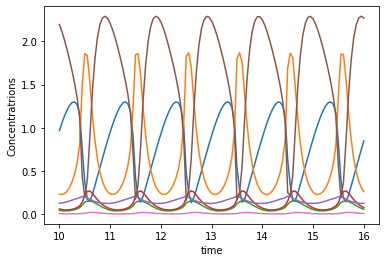

In [7]:
def plot_time_series(num_IC,t_span,data): #function to plot difference in training, cross validation and test data
    for i in np.arange(0,num_IC):
        fig = plt.plot(t_span,np.transpose(data[:,:,i]))
        plt.xlabel('time')
        plt.ylabel('Concentratrions')
        return fig

fig_train = plot_time_series(num_train,seen_span,training_data)


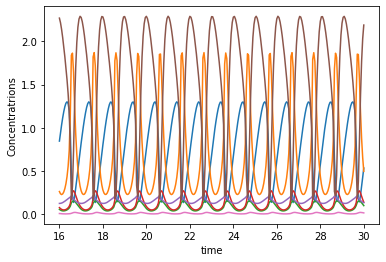

In [8]:
fig_cv = plot_time_series(num_train,unseen_span,cv_data)

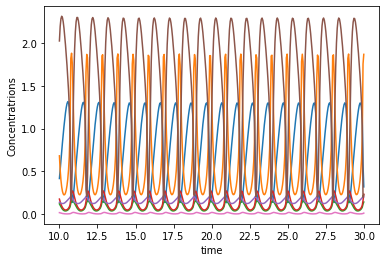

In [9]:
fig_test = plot_time_series(num_test,test_span,test_data)

### Koopman operator matrix representation

In [10]:
if DMD_type == 'DMD':
    basis_order = 1

import DMD_algorithms #importing DMD algorithms module
#print(training_data.shape)
DMD = getattr(DMD_algorithms, DMD_type) #calling specific DMD algorithm
G, A, K, C = DMD(training_data,basis_type,basis_order) # K approximation using one step estimation
print('Size of K: ', K.shape)
print('Size of C: ', C.shape)

print('Rank of G: ', np.linalg.matrix_rank(G))
print('Condition number of G: ', np.linalg.cond(G))
print('Rank of A: ', np.linalg.matrix_rank(A))
print('Condition number of A: ', np.linalg.cond(A))
print('Rank of K: ', np.linalg.matrix_rank(K))
print('Condition number of K: ', np.linalg.cond(K))
print('Rank of C: ', np.linalg.matrix_rank(C))
print('Condition number of C: ', np.linalg.cond(C))


Size of K:  (50, 50)
Size of C:  (50, 7)
Rank of G:  18
Condition number of G:  1.0427168021681216e+26
Rank of A:  18
Condition number of A:  1.8773088945933444e+26
Rank of K:  43
Condition number of K:  3.55573127446238e+17
Rank of C:  7
Condition number of C:  80.63652678157234


### Predictions and Error (Not ready for HankelDMD)

In [11]:
import Prediction  #importing one step and N step predictor modules
prediction = getattr(Prediction, step)  #calling specific predictor

training_data_est, training_error = prediction(training_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of minimization using inversion
cv_data_est, cv_error = prediction(cv_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of error on future of trajectories used to train
test_data_est, test_error = prediction(test_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of prediction on unseen initial conditions
#Errors only in state
# *_data_est is full observables
print('Error on used data: ', "{0:0f}%".format(training_error *100))
print('Error on unused from same trajectories: ', "{0:0f}%".format(cv_error *100))
print('Error on different trajectories: ', "{0:0f}%".format(test_error *100))
# print(lifted_training_data_est.shape)
# print(lifted_cv_data_est.shape)
# print(lifted_test_data_est.shape)


Error on used data:  4.412486%
Error on unused from same trajectories:  5.028297%
Error on different trajectories:  14.504338%
